# **Import Library**

In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.7 MB/s eta 0:00:00


In [ ]:
%pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 20.5 MB/s eta 0:00:00


In [ ]:
import os
import yaml
import random
import shutil
from collections import Counter, defaultdict
from PIL import Image
import imagehash
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from glob import glob
from google.colab import files
import albumentations as A

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/data.zip -d /content/data

Archive:  /content/drive/MyDrive/Datasets/data.zip
   creating: /content/data/images/
  inflating: /content/data/images/-1-b25baf4e22c5b4f886219189ec0dff25-d1ee1e8e31dab310275e182e5e3a67a0_600x400_jpg.rf.72076a0e3674e27a2154629ed1280f3b.jpg  
  inflating: /content/data/images/-1024x708_jpg.rf.5a8abc3078cc17c524cbe2b998475e02.jpg  
  inflating: /content/data/images/-_-_-_-_-_-_jpg.rf.81cf18d6b73288ef6481cbe21541eb9e.jpg  
  inflating: /content/data/images/-_-_-_-_-_jpg.rf.3b32edadbafa6aef2f631aedd4a01676.jpg  
  inflating: /content/data/images/-_jpeg.rf.543e74bfdffe75cea652421a28b2b639.jpg  
  inflating: /content/data/images/-_jpeg.rf.a049e15b4038bdfee8d01625ae84435b.jpg  
  inflating: /content/data/images/-_jpg.rf.07256be3a681b5992d2a1e2f4b6d1895.jpg  
  inflating: /content/data/images/-_jpg.rf.55b9be82fdf49b586ab19613d49ed523.jpg  
  inflating: /content/data/images/-_jpg.rf.7da56dfbe256da08a779d6f40fca31b8.jpg  
  inflating: /content/data/images/-_jpg.rf.8747b4855069b3a8e0811cb57b5cd6

# **Data Preprocessing**

In [ ]:
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

Detect Null Annotations

In [ ]:
OUTPUT_IMG_DIR_NON_ANNOT = "data/no_annotations/images"
OUTPUT_LABEL_DIR_NON_ANNOT = "data/no_annotations/labels"

os.makedirs(OUTPUT_IMG_DIR_NON_ANNOT, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR_NON_ANNOT, exist_ok=True)

In [ ]:
valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
image_files = [
    os.path.join(IMG_DIR, f)
    for f in os.listdir(IMG_DIR)
    if f.endswith(valid_exts)
]

display(f"Total Images: {len(image_files)}")

no_ann_count = 0

for img_path in image_files:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABEL_DIR, base + ".txt")

    move_flag = False

    # Case 1: Missing annotation file
    if not os.path.exists(label_path):
        move_flag = True

    # Case 2: Empty annotation file
    elif os.path.getsize(label_path) == 0:
        move_flag = True
        # Move the empty annotation file too
        shutil.move(label_path, os.path.join(OUTPUT_LABEL_DIR_NON_ANNOT, os.path.basename(label_path)))

    # Move image if flagged
    if move_flag:
        shutil.move(img_path, os.path.join(OUTPUT_IMG_DIR_NON_ANNOT, os.path.basename(img_path)))
        no_ann_count += 1

print(f"Moved {no_ann_count} images with no annotations (and their empty labels if any).")

'Total Images: 1552'

Moved 0 images with no annotations (and their empty labels if any).


Filter Blurry Imnages

In [ ]:
OUTPUT_IMG_DIR_BLUR = "data/blurred/images"
OUTPUT_LABEL_DIR_BLUR = "data/blurred/labels"
os.makedirs(OUTPUT_IMG_DIR_BLUR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR_BLUR, exist_ok=True)

In [ ]:
valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
image_files = [
    os.path.join(IMG_DIR, f)
    for f in os.listdir(IMG_DIR)
    if f.endswith(valid_exts)
]

display(f"Total Images: {len(image_files)}")

# Laplacian variance threshold
THRESHOLD = 100  # adjust for your dataset

def laplacian_variance(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

blurry_count = 0

for img_path in image_files:
    score = laplacian_variance(img_path)

    if score < THRESHOLD:
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(LABEL_DIR, base + ".txt")

        # Move image
        shutil.move(img_path, os.path.join(OUTPUT_IMG_DIR_BLUR, os.path.basename(img_path)))

        # Move label if exists
        if os.path.exists(label_path):
            shutil.move(label_path, os.path.join(OUTPUT_LABEL_DIR_BLUR, os.path.basename(label_path)))

        blurry_count += 1
        print(f"Moved blurry image: {base} (score={score:.2f})")

print(f"\n✅ Done! Moved {blurry_count} blurry images (and their labels if available).")

'Total Images: 1552'

Moved blurry image: images-51-_jpg.rf.b49cd4121280f219fdaf6d3ccea8a58d (score=83.28)
Moved blurry image: IMG_E3909_JPG.rf.20c009b454a79f45c5f5bc9f34e2a03b (score=87.07)
Moved blurry image: rice-107_jpg.rf.ee79786eba1cebc435ba267a43a3081c (score=68.24)
Moved blurry image: 59_jpg.rf.c5f8695447cd4cf23bd3dc8459ab30a1 (score=52.17)
Moved blurry image: tahu-goreng-gurih-foto-resep-utama_jpg.rf.0c795e9444970c760e4f59f8afc0a070 (score=37.80)
Moved blurry image: rice-94_jpg.rf.eac97a8fec91df7b04372087556904ff (score=70.09)
Moved blurry image: IMG_E3904_JPG.rf.89e1f5243f26a98bd2c8d1f08b41c939 (score=90.06)
Moved blurry image: IMG_E3978_JPG.rf.978c52d648651132e9c1016d03aeaf0b (score=84.48)
Moved blurry image: IMG_3900_JPG.rf.f3f4a692ef26360b002c582260a227c9 (score=70.15)
Moved blurry image: images-39-_jpg.rf.18dd42c39936948c0c4d8a46ffed7570 (score=87.95)
Moved blurry image: IMG_3893_JPG.rf.8fe158a878fa30fe90450bc0c60c7086 (score=44.14)
Moved blurry image: IMG_E3900_JPG.rf.ddc566593b2efde3d771a299

Similarity Check

In [ ]:
DUP_IMG_DIR = "data/duplicates/images"
DUP_LBL_DIR = "data/duplicates/labels"

# Create duplicate folders if not exists
os.makedirs(DUP_IMG_DIR, exist_ok=True)
os.makedirs(DUP_LBL_DIR, exist_ok=True)

In [ ]:
# Collect all image files
valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
image_files = [
    os.path.join(IMG_DIR, f)
    for f in os.listdir(IMG_DIR)
    if f.endswith(valid_exts)
]

display(f"Total Images: {len(image_files)}")

# Store seen hashes
seen_hashes = {}
threshold = 5  # Hamming distance tolerance (0 = exact match, 5 = near duplicates)
duplicate_count = 0  # counter

for img_path in image_files:
    try:
        img = Image.open(img_path)
        phash = imagehash.phash(img)

        is_duplicate = False
        for seen_path, seen_hash in seen_hashes.items():
            if phash - seen_hash <= threshold:
                # Move duplicate image
                filename = os.path.basename(img_path)
                new_img_path = os.path.join(DUP_IMG_DIR, filename)
                shutil.move(img_path, new_img_path)
                print(f"🔁 Moved duplicate image: {img_path} -> {new_img_path}")

                # Move corresponding label if exists
                label_name = os.path.splitext(filename)[0] + ".txt"
                label_path = os.path.join(LABEL_DIR, label_name)
                if os.path.exists(label_path):
                    new_lbl_path = os.path.join(DUP_LBL_DIR, label_name)
                    shutil.move(label_path, new_lbl_path)
                    print(f"   ↪ Also moved label: {label_path} -> {new_lbl_path}")

                duplicate_count += 1
                is_duplicate = True
                break

        if not is_duplicate:
            seen_hashes[img_path] = phash

    except Exception as e:
        print(f"⚠️ Error reading {img_path}: {e}")

print("\n✅ Done!")
print(f"📊 Total duplicate images moved: {duplicate_count}")

'Total Images: 1308'

🔁 Moved duplicate image: data/images/IMG_3957_JPG.rf.86d9548eccadbbf4a39cddde7fef063a.jpg -> data/duplicates/images/IMG_3957_JPG.rf.86d9548eccadbbf4a39cddde7fef063a.jpg
   ↪ Also moved label: data/labels/IMG_3957_JPG.rf.86d9548eccadbbf4a39cddde7fef063a.txt -> data/duplicates/labels/IMG_3957_JPG.rf.86d9548eccadbbf4a39cddde7fef063a.txt
🔁 Moved duplicate image: data/images/IMG_3920_JPG.rf.244f45f697af7dce21bfb2cf6e9a17e4.jpg -> data/duplicates/images/IMG_3920_JPG.rf.244f45f697af7dce21bfb2cf6e9a17e4.jpg
   ↪ Also moved label: data/labels/IMG_3920_JPG.rf.244f45f697af7dce21bfb2cf6e9a17e4.txt -> data/duplicates/labels/IMG_3920_JPG.rf.244f45f697af7dce21bfb2cf6e9a17e4.txt
🔁 Moved duplicate image: data/images/IMG_3931_JPG.rf.8168f047be3e556a29f3b619892ddf3c.jpg -> data/duplicates/images/IMG_3931_JPG.rf.8168f047be3e556a29f3b619892ddf3c.jpg
   ↪ Also moved label: data/labels/IMG_3931_JPG.rf.8168f047be3e556a29f3b619892ddf3c.txt -> data/duplicates/labels/IMG_3931_JPG.rf.8168f047be3e556a29f3b619892dd

Count Images Each Class

In [ ]:
# Class mapping
class_names = {
    0: "nasi putih",
    1: "tahu",
    2: "tempe",
    3: "ikan",
    4: "ayam"
}

# Get all label files
label_files = glob(os.path.join(LABEL_DIR, "*.txt"))

counts = Counter()

for label_path in label_files:
    with open(label_path, "r") as f:
        for line in f:
            if line.strip():  # skip empty lines
                class_id = int(line.split()[0])
                counts[class_id] += 1

# Print results
print("📊 Object Counts in Dataset (by labels):")
for cid, cname in class_names.items():
    print(f"{cname:10s} ({cid}) : {counts[cid]}")

valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
image_files = [
    os.path.join(IMG_DIR, f)
    for f in os.listdir(IMG_DIR)
    if f.endswith(valid_exts)
]
display(f"Total Images: {len(image_files)}")

📊 Object Counts in Dataset (by labels):
nasi putih (0) : 404
tahu       (1) : 909
tempe      (2) : 726
ikan       (3) : 375
ayam       (4) : 672


'Total Images: 1029'

In [ ]:
valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

small_images = []
total_images = 0

for fname in os.listdir(IMG_DIR):
    if fname.endswith(valid_exts):
        total_images += 1
        path = os.path.join(IMG_DIR, fname)
        with Image.open(path) as img:
            w, h = img.size
            if w < 640 or h < 640:
                small_images.append((fname, w, h))

print(f"📊 Total images: {total_images}")
print(f"🔎 Images smaller than 640x640: {len(small_images)}")

# Show some examples
for name, w, h in small_images[:10]:  # only print first 10
    print(f"   {name} -> {w}x{h}")

📊 Total images: 1029
🔎 Images smaller than 640x640: 712
   images33_jpg.rf.a8ca3858ee3199250135d386a1e9955c.jpg -> 416x416
   rice-34_jpg.rf.eca59ba48864ab7530154168f60f586d.jpg -> 200x200
   ayam-goreng-tanpa-tepung-foto-resep-utama_jpg.rf.3c5ed3c83fde364734fb97632800a142.jpg -> 416x416
   ayam-goreng-kunyit-sederhana-foto-resep-utama_jpg.rf.f524992c55dc9e782e8b560fb85edbc7.jpg -> 416x416
   nasi-putih_6_jpg.rf.9413a4eade36f85cd59c7818d4a64bda.jpg -> 200x200
   photo--1-_jpg.rf.23d1a8db07bf73dfb3e238b8b9862871.jpg -> 416x416
   rice-38_jpg.rf.1c6de5e1b24ad041b3c52297729d7050.jpg -> 200x200
   cbe97b4f-ayam-goreng-24-_jpg.rf.03499ac6f59bade1f28fd67bbe047c08.jpg -> 224x224
   fried-fish-carp-fresh-vegetable-260nw-640507978_jpg.rf.c0fc42427056f6ddc99e340bddac58b2.jpg -> 416x416
   rice-36_jpg.rf.79af944e9fe53e4c7f12db66b99caab9.jpg -> 200x200


Download Folder Data

In [ ]:
# Folder you want to download
folder_path = "data"   # change this to your folder

# Zip the folder
shutil.make_archive("data_filtered", 'zip', folder_path)

# Download the zipped folder
files.download("data_filtered.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Data Augmentation**

In [ ]:
!unzip data_filtered.zip -d /content/data

Archive:  data_filtered.zip
   creating: /content/data/blurred/
   creating: /content/data/duplicates/
   creating: /content/data/images/
   creating: /content/data/labels/
   creating: /content/data/no_annotations/
  inflating: /content/data/classes.txt  
  inflating: /content/data/labels/images-16-_jpg.rf.731611e5077d26c2db7adb187a4fe14b.txt  
  inflating: /content/data/labels/images-37-_jpg.rf.269cb8128d74057474e27e5086088722.txt  
  inflating: /content/data/labels/IMG_3956_JPG.rf.589eddbed9f1720ac4a204d4ff974775.txt  
  inflating: /content/data/labels/rice-108_jpg.rf.f13a5d99436aa8000628568c800c7d2b.txt  
  inflating: /content/data/labels/maxresdefault--7-_jpg.rf.c32dd2be258dd9f88296fe246ac172af.txt  
  inflating: /content/data/labels/download_jpg.rf.ccab9cc3b906bc3c21436c23bab78b69.txt  
  inflating: /content/data/labels/rice-52_jpg.rf.2471adcb5075049a66a4a7079c9a833a.txt  
  inflating: /content/data/labels/nasi-putih_27_jpg.rf.e78d9370b09249cb9bd7a625e545a67a.txt  
  inflating: /

In [ ]:
IMG_DIR = "data/images"
LBL_DIR = "data/labels"
OUT_IMG_DIR = "data/images_aug"
OUT_LBL_DIR = "data/labels_aug"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LBL_DIR, exist_ok=True)

In [ ]:
# Class IDs
CLASS_NAMES = {
    0: "nasi_putih",
    1: "tahu",
    2: "tempe",
    3: "ikan",
    4: "ayam"
}
TARGET_CLASSES = [1, 2, 3, 4]  # augment only these

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.ColorJitter(p=0.3)
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels'],
    min_visibility=0.2,
    clip=True,
    check_each_transform=False
))

# --- Step 1: Count class distribution ---
counts = Counter()
for lbl_path in glob(os.path.join(LBL_DIR, "*.txt")):
    with open(lbl_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        cls = int(line.split()[0])
        counts[cls] += 1

print("\n📊 Current class distribution:")
for cid, cnt in counts.items():
    print(f" {CLASS_NAMES.get(cid,cid)}: {cnt}")

max_count = max(counts.values())
print(f"\n⚖️ Target samples per class: {max_count}")

# --- Step 2: Augment until balanced ---
aug_count = 0
for lbl_path in glob(os.path.join(LBL_DIR, "*.txt")):
    with open(lbl_path, "r") as f:
        lines = f.readlines()

    # parse labels
    bboxes, cls_labels = [], []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            cls = int(parts[0])
            x, y, bw, bh = map(float, parts[1:5])
            bboxes.append([x, y, bw, bh])
            cls_labels.append(cls)

    if not bboxes:
        continue

    base = os.path.splitext(os.path.basename(lbl_path))[0]
    img_path = os.path.join(IMG_DIR, base + ".jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(IMG_DIR, base + ".JPG")
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)

    # for each class in this image that needs balancing
    for cid in set(cls_labels):
        if cid in TARGET_CLASSES and counts[cid] < max_count:
            need = max_count - counts[cid]

            # generate augmentations until balance reached
            gen = 0
            while gen < need:
                augmented = transform(image=img, bboxes=bboxes, class_labels=cls_labels)
                aug_img = augmented["image"]
                aug_bboxes = augmented["bboxes"]
                aug_labels = augmented["class_labels"]

                if not aug_bboxes:
                    continue

                out_img_path = os.path.join(OUT_IMG_DIR, base + f"_aug{aug_count}.jpg")
                out_lbl_path = os.path.join(OUT_LBL_DIR, base + f"_aug{aug_count}.txt")

                cv2.imwrite(out_img_path, aug_img)
                with open(out_lbl_path, "w") as f:
                    for c, (x, y, bw, bh) in zip(aug_labels, aug_bboxes):
                        f.write(f"{c} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

                counts[cid] += 1
                aug_count += 1
                gen += 1

                print(f"✅ Augmented {CLASS_NAMES[cid]} -> total {counts[cid]}")

print("\n🎉 Balancing complete!")
print("📊 Final class distribution:")
for cid, cnt in counts.items():
    print(f" {CLASS_NAMES.get(cid,cid)}: {cnt}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



📊 Current class distribution:
 tahu: 1550
 nasi_putih: 769
 tempe: 1009
 ayam: 681
 ikan: 390

⚖️ Target samples per class: 1550
✅ Augmented tempe -> total 1010
✅ Augmented tempe -> total 1011
✅ Augmented tempe -> total 1012
✅ Augmented tempe -> total 1013
✅ Augmented tempe -> total 1014
✅ Augmented tempe -> total 1015
✅ Augmented tempe -> total 1016
✅ Augmented tempe -> total 1017
✅ Augmented tempe -> total 1018
✅ Augmented tempe -> total 1019
✅ Augmented tempe -> total 1020
✅ Augmented tempe -> total 1021
✅ Augmented tempe -> total 1022
✅ Augmented tempe -> total 1023
✅ Augmented tempe -> total 1024
✅ Augmented tempe -> total 1025
✅ Augmented tempe -> total 1026
✅ Augmented tempe -> total 1027
✅ Augmented tempe -> total 1028
✅ Augmented tempe -> total 1029
✅ Augmented tempe -> total 1030
✅ Augmented tempe -> total 1031
✅ Augmented tempe -> total 1032
✅ Augmented tempe -> total 1033
✅ Augmented tempe -> total 1034
✅ Augmented tempe -> total 1035
✅ Augmented tempe -> total 1036
✅ Augm

# **Data Splitting**

Non Augmented

In [ ]:
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"
OUTPUT_SPLIT_DIR = "data_split"

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Collect all images
valid_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
images = [f for f in glob(os.path.join(IMG_DIR, "*")) if f.endswith(valid_exts)]
random.shuffle(images)

# Split
n_total = len(images)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

train_files = images[:n_train]
val_files = images[n_train:n_train+n_val]
test_files = images[n_train+n_val:]

splits = {
    "train": train_files,
    "val": val_files,
    "test": test_files
}

# Create output folders
for split in splits:
    os.makedirs(os.path.join(OUTPUT_SPLIT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_SPLIT_DIR, split, "labels"), exist_ok=True)

# Copy files
for split, files in splits.items():
    for img_path in files:
        fname = os.path.basename(img_path)
        name_no_ext = os.path.splitext(fname)[0]

        # Image
        shutil.copy(img_path, os.path.join(OUTPUT_SPLIT_DIR, split, "images", fname))

        # Label
        lbl_path = os.path.join(LABEL_DIR, name_no_ext + ".txt")
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, os.path.join(OUTPUT_SPLIT_DIR, split, "labels", name_no_ext + ".txt"))

print(f"✅ Dataset split complete! Total: {n_total}")
print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

✅ Dataset split complete! Total: 1552
Train: 1086, Val: 310, Test: 156


Augmented

In [ ]:
# Paths
ORIG_IMG_DIR = "data/images"
ORIG_LBL_DIR = "data/labels"
AUG_IMG_DIR  = "data/images_aug"
AUG_LBL_DIR  = "data/labels_aug"

OUT_DIR = "data_split"
IMG_OUT = os.path.join(OUT_DIR, "images")
LBL_OUT = os.path.join(OUT_DIR, "labels")

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(IMG_OUT, split), exist_ok=True)
    os.makedirs(os.path.join(LBL_OUT, split), exist_ok=True)

# Collect files (original + augmented)
all_images = glob(os.path.join(ORIG_IMG_DIR, "*.jpg")) + glob(os.path.join(ORIG_IMG_DIR, "*.JPG"))
all_labels = {os.path.splitext(os.path.basename(f))[0]: f for f in glob(os.path.join(ORIG_LBL_DIR, "*.txt"))}

aug_images = glob(os.path.join(AUG_IMG_DIR, "*.jpg")) + glob(os.path.join(AUG_IMG_DIR, "*.JPG"))
aug_labels = {os.path.splitext(os.path.basename(f))[0]: f for f in glob(os.path.join(AUG_LBL_DIR, "*.txt"))}

all_data = []
for img in all_images + aug_images:
    base = os.path.splitext(os.path.basename(img))[0]
    if base in all_labels:
        lbl = all_labels[base]
    elif base in aug_labels:
        lbl = aug_labels[base]
    else:
        continue  # skip images without label
    all_data.append((img, lbl))

print(f"📊 Total combined dataset: {len(all_data)} samples")

# Shuffle
random.shuffle(all_data)

# Split ratio
train_ratio, val_ratio = 0.7, 0.2
train_end = int(len(all_data) * train_ratio)
val_end   = train_end + int(len(all_data) * val_ratio)

splits = {
    "train": all_data[:train_end],
    "val": all_data[train_end:val_end],
    "test": all_data[val_end:]
}

# Copy files
for split, items in splits.items():
    for img, lbl in items:
        shutil.copy(img, os.path.join(IMG_OUT, split, os.path.basename(img)))
        shutil.copy(lbl, os.path.join(LBL_OUT, split, os.path.basename(lbl)))
    print(f"✅ {split}: {len(items)} samples")

print("\n🎉 Dataset splitting complete!")

📊 Total combined dataset: 4076 samples
✅ train: 2853 samples
✅ val: 815 samples
✅ test: 408 samples

🎉 Dataset splitting complete!


# **Model Training**

In [ ]:
shutil.rmtree("runs", ignore_errors=True)

Craete data.yaml

Non Augmented

In [ ]:
data = {
    'path': 'data_split',
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': 5,
    'names': ["nasi putih", "tahu", "tempe", "ikan", "ayam"]
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False, sort_keys=False)

print("✅ data.yaml created!")

✅ data.yaml created!


Augmented

In [ ]:
data = {
    'path': 'data_split',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 5,
    'names': ["nasi putih", "tahu", "tempe", "ikan", "ayam"]
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False, sort_keys=False)

print("✅ data.yaml created!")

In [ ]:
!yolo train data=data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

In [ ]:
# Load a pre-trained YOLOv8 model (choose nano, small, medium, etc.)
model = YOLO('yolov8s.pt')  # 'n' = nano, 's' = small, 'm' = medium

# Train
model.train(
    data='data.yaml',
    epochs=60,
    imgsz=640,
    batch=16,
)

FileNotFoundError: [Errno 2] No such file or directory: 'yolov11s.pt'

In [ ]:
# Load best trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Run validation
metrics = model.val(data="data.yaml", split="val", plots=True)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 977.4±651.4 MB/s, size: 28.6 KB)
val: Scanning /content/data_split/val/labels.cache... 310 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 310/310 594.5Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 84, len(boxes) = 911. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 5.5it/s 3.6s
                   all        310        911      0.834      0.818      0.853      0.625
            nasi putih        142        145          1      0.993      0.995      0.915
                  tahu         52      

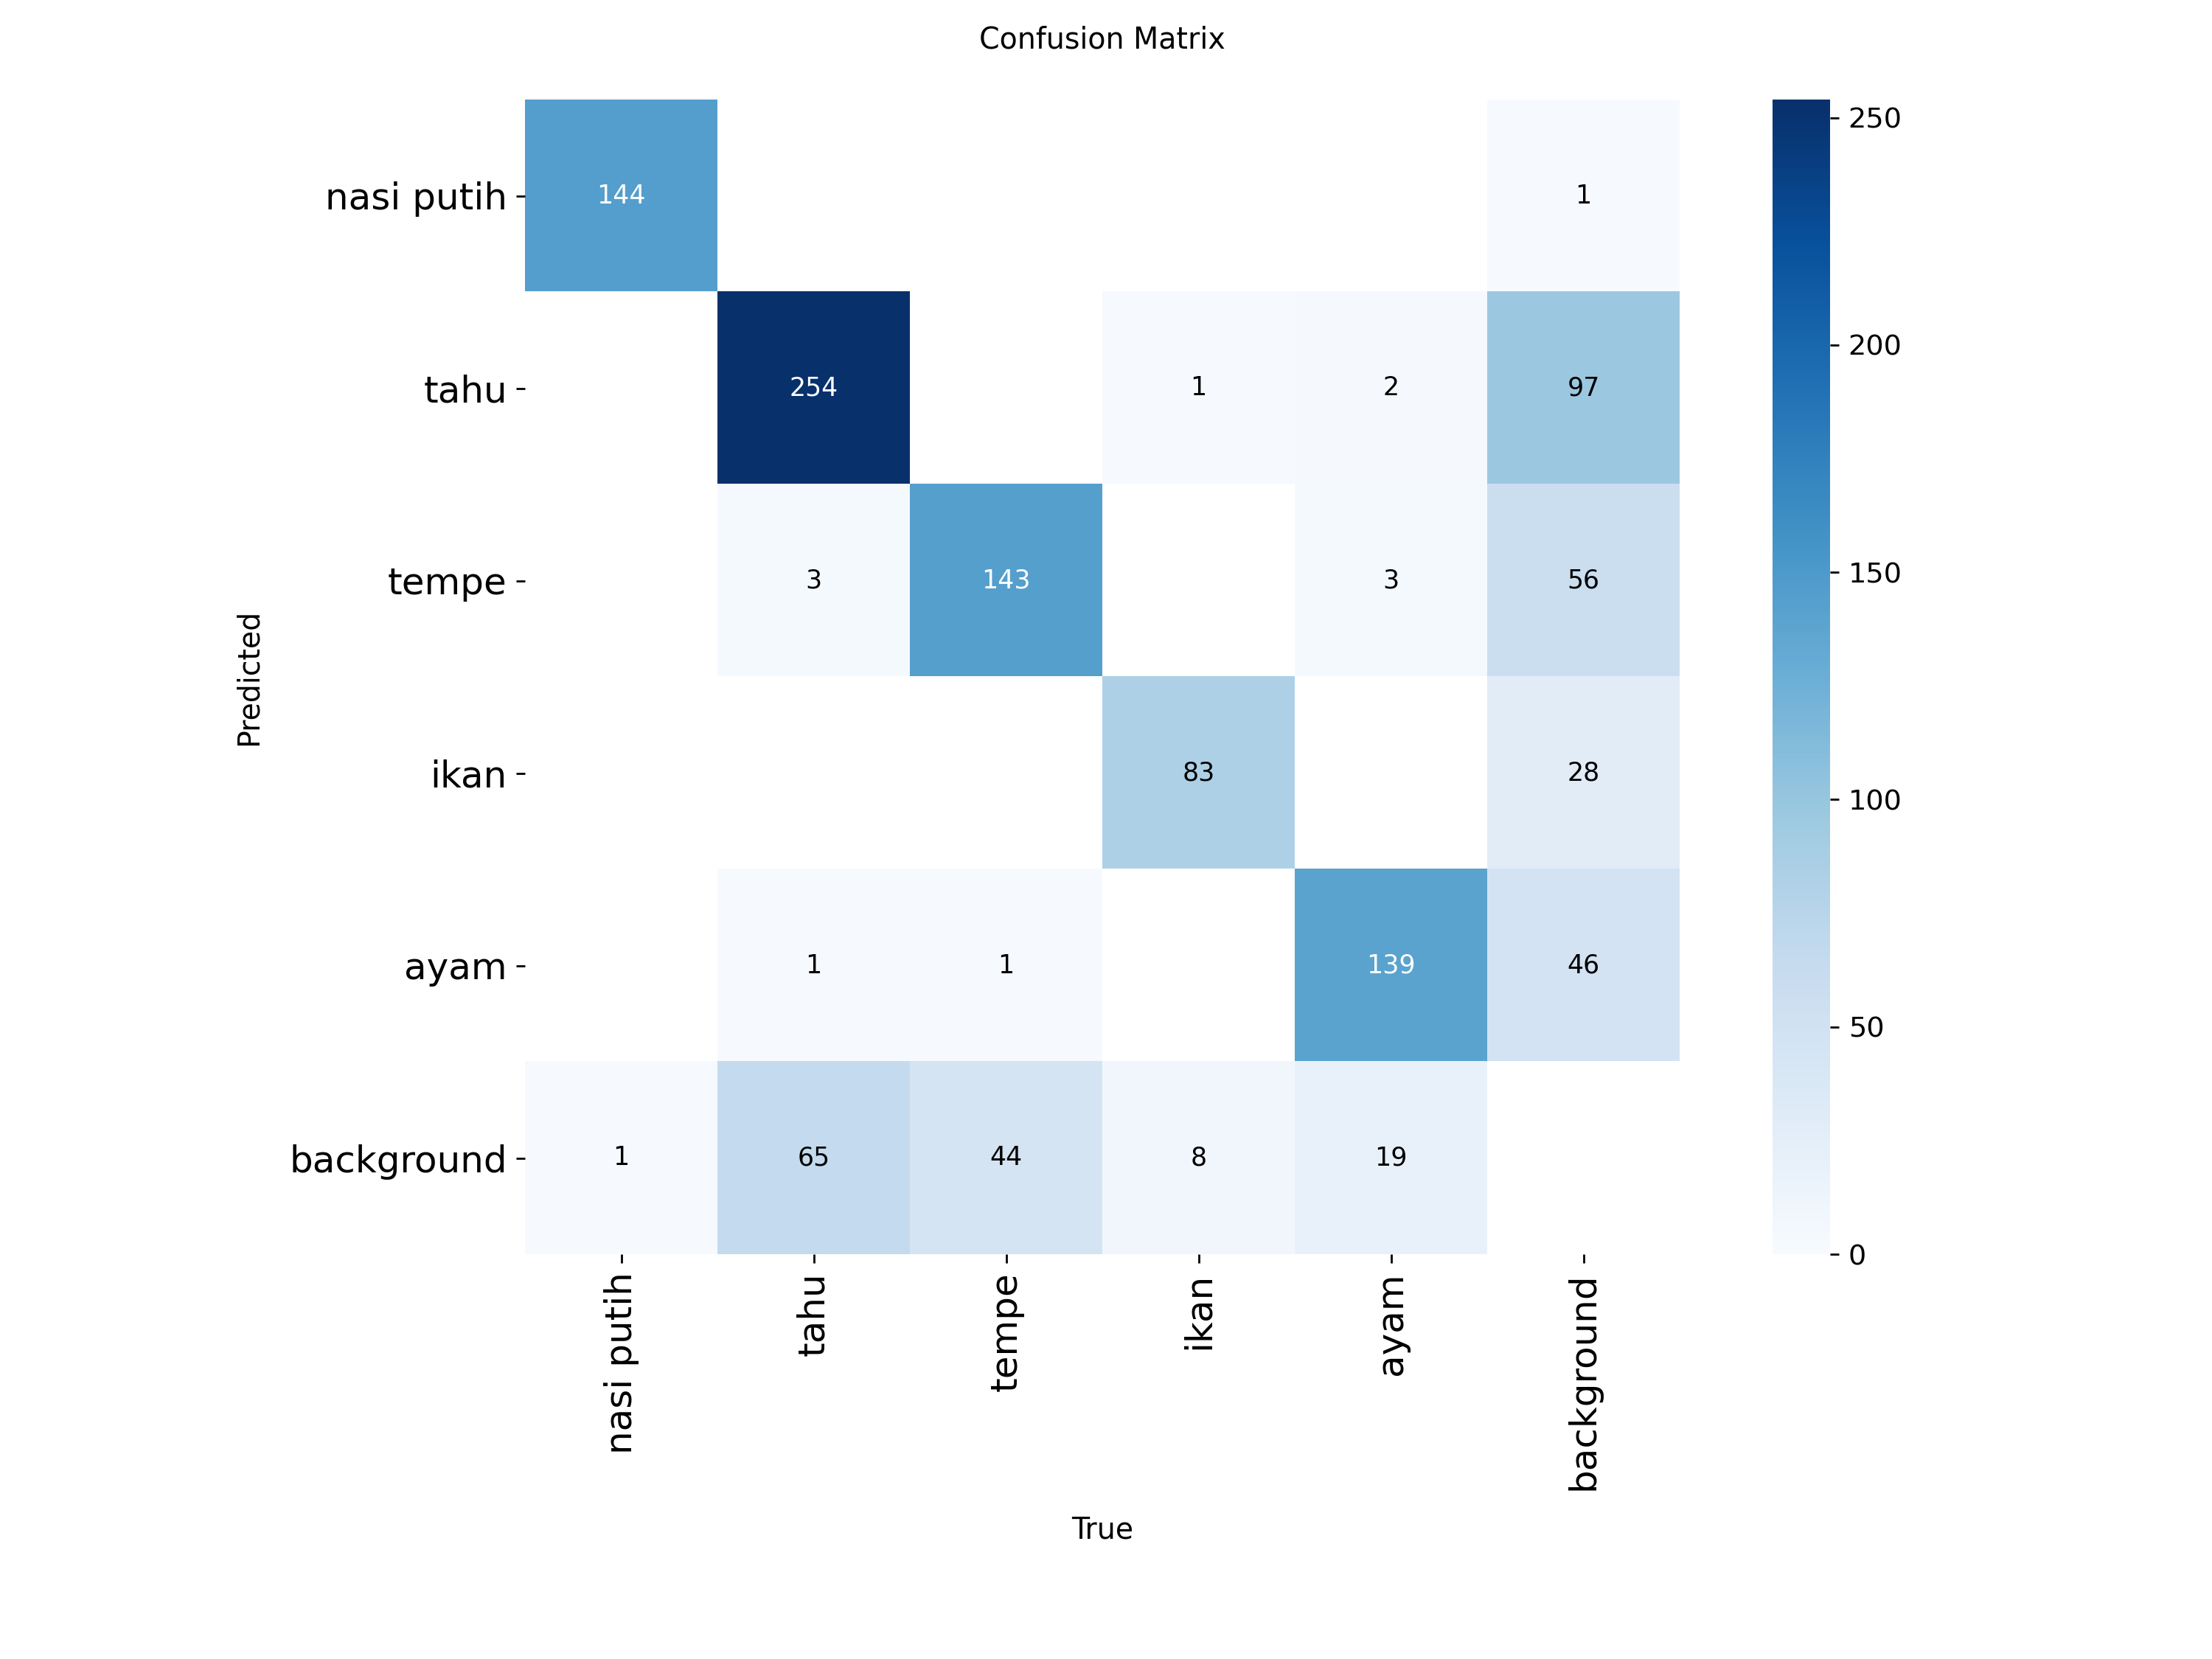

In [ ]:
img = cv2.imread("runs/detect/val/confusion_matrix.png")
cv2_imshow(img)

In [ ]:
# Load your trained model (replace with your path if needed)
model = YOLO("runs/detect/train/weights/best.pt")

# Evaluate on test set
metrics = model.val(
    data="data.yaml",   # your dataset config
    split="test",       # use test split instead of val
    imgsz=640,          # image size
    conf=0.5            # confidence threshold
)

# Print overall metrics
print("\n📊 Overall Metrics")
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")

# Print per-class metrics
print("\n🔎 Per-class mAP:")
for cls_id, m in enumerate(metrics.box.maps):
    print(f"Class {cls_id} → {m:.3f}")

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1054.7±474.1 MB/s, size: 38.4 KB)
val: Scanning /content/data_split/test/labels... 156 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 156/156 1.6Kit/s 0.1s
val: New cache created: /content/data_split/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 32, len(boxes) = 470. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 4.3it/s 2.3s
                   all        156        470      0.835      0.673      0.772      0.637
            nasi putih         82         83      0.958      0.988      

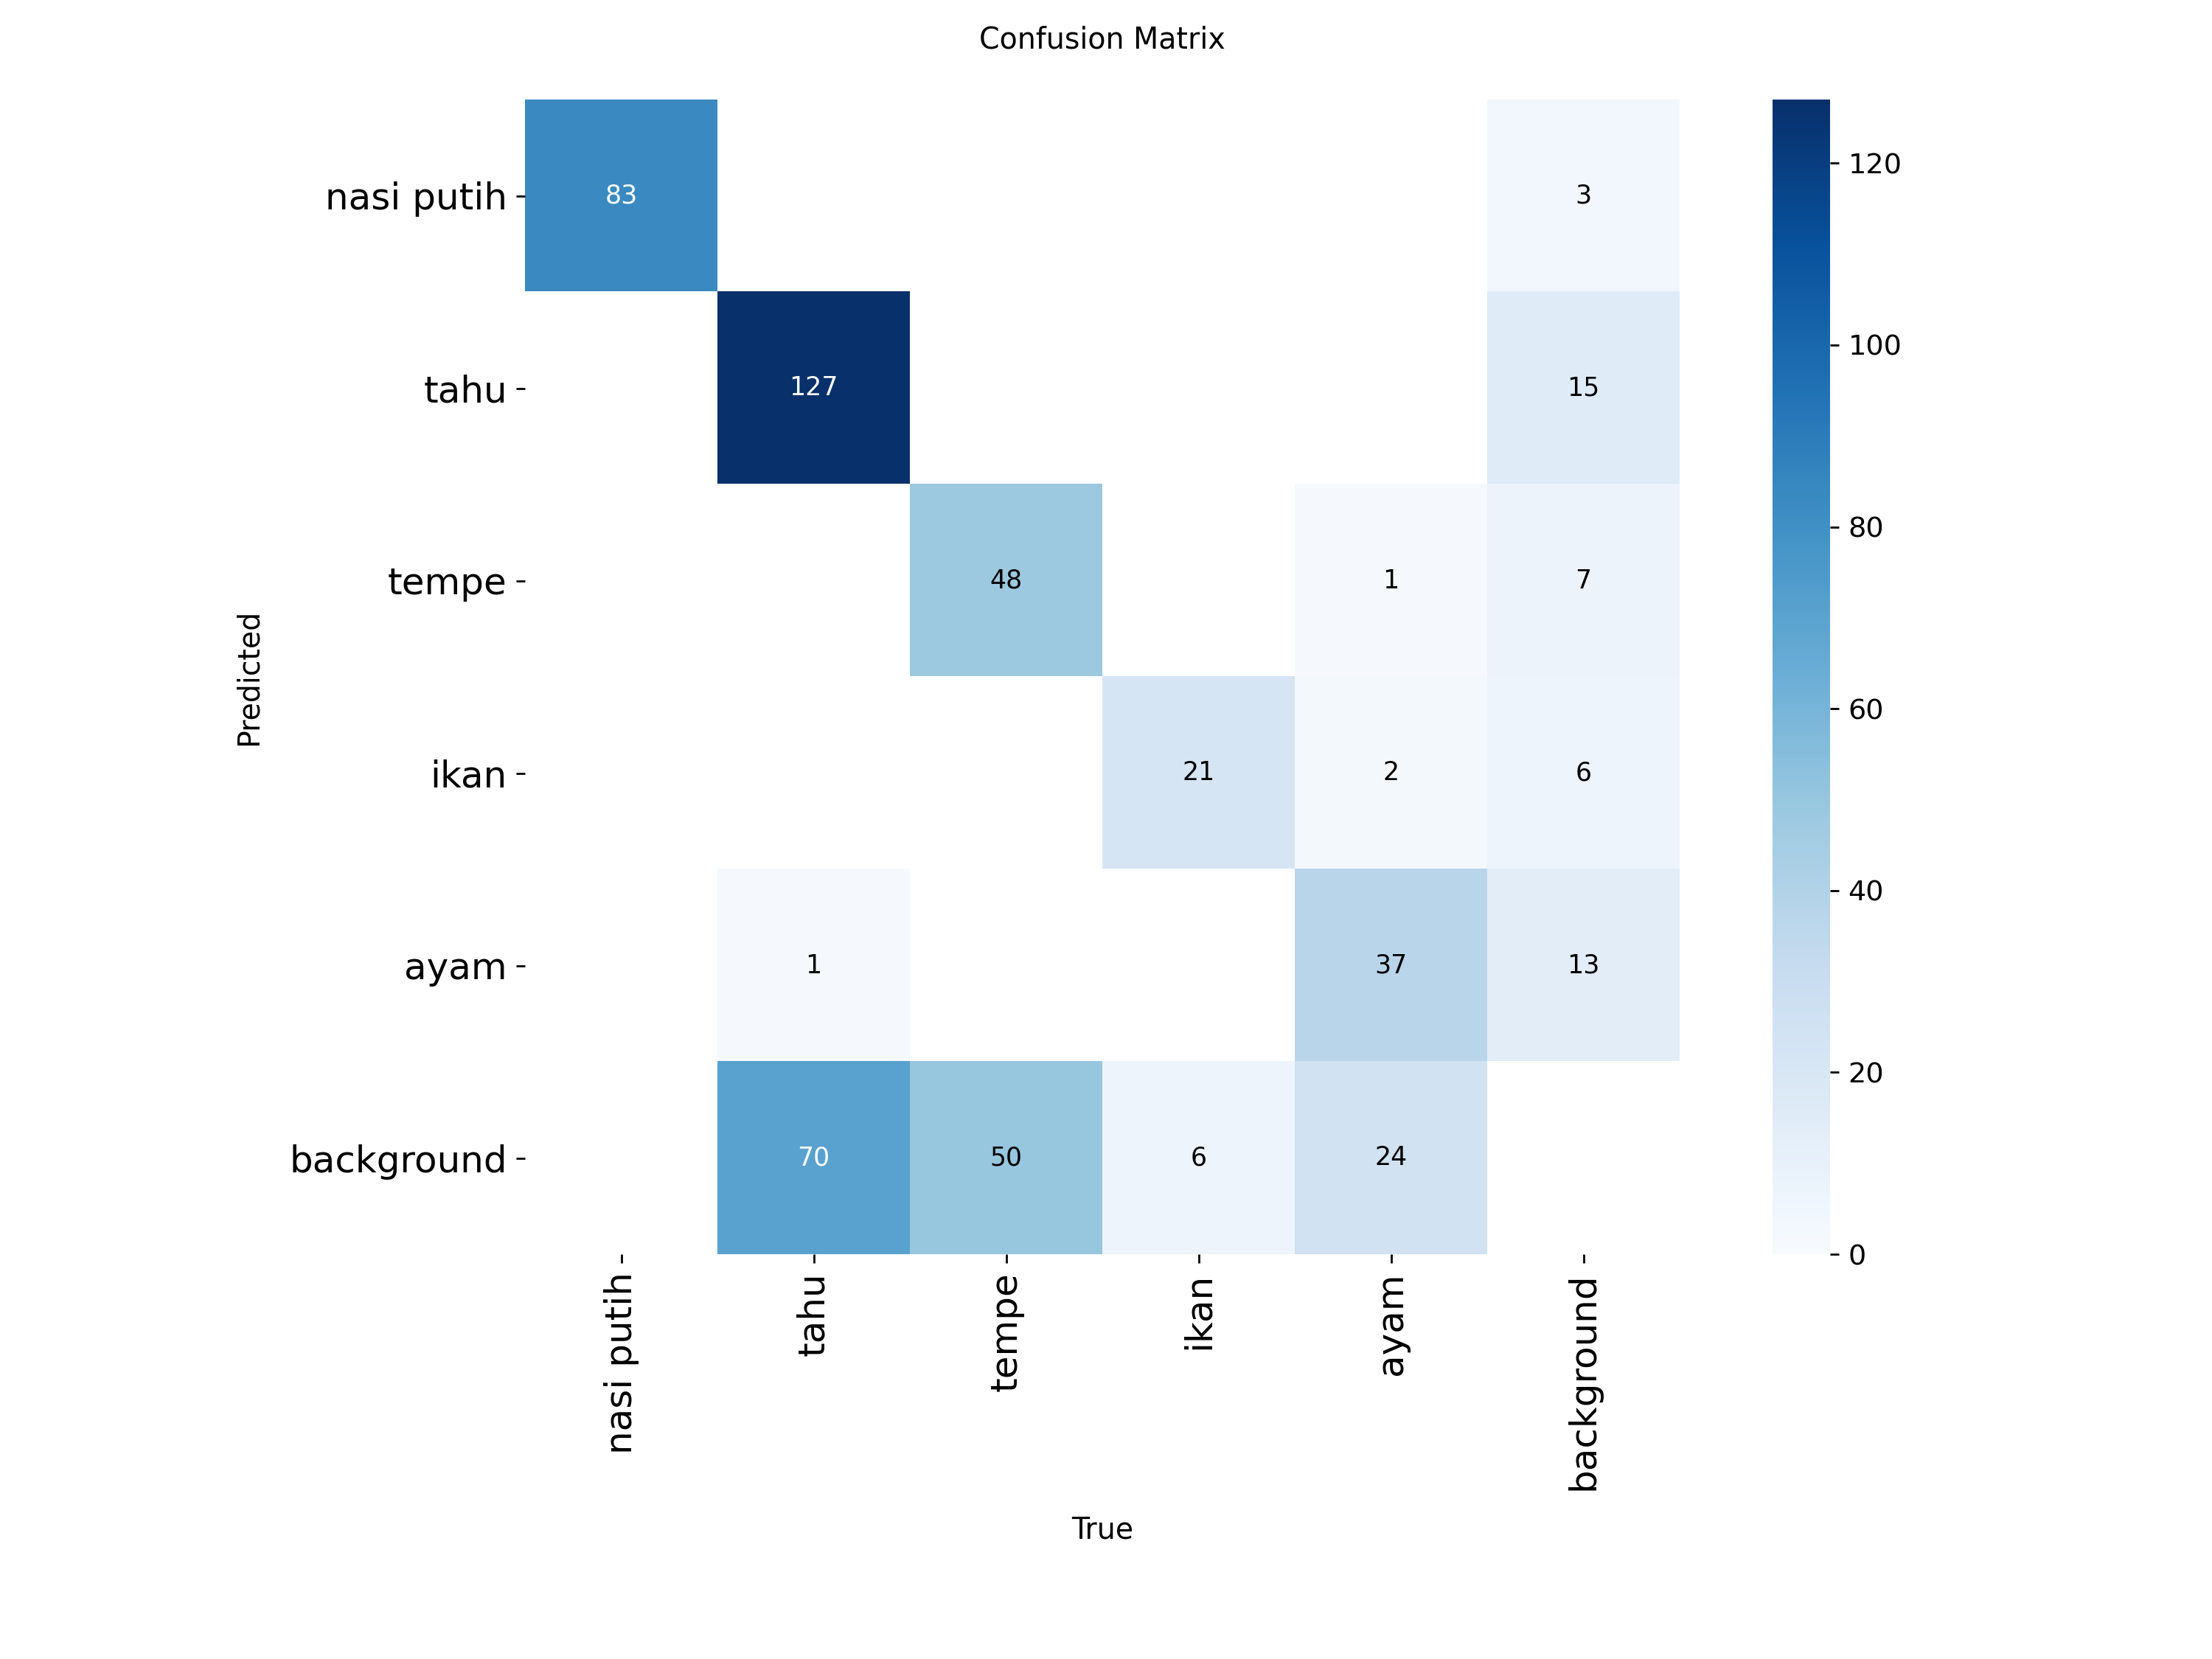

In [ ]:
img = cv2.imread("runs/detect/val2/confusion_matrix.png")
cv2_imshow(img)

# **Testing from Photo**

In [ ]:
!unzip yolo_test.zip

Archive:  yolo_test.zip
   creating: yolo_test/
  inflating: yolo_test/ayam-nasi.jpg  
  inflating: yolo_test/gambar-1.jpg  
  inflating: yolo_test/gambar-2.jpg  
  inflating: yolo_test/gambar-3.jpg  
  inflating: yolo_test/gambar-4.jpg  
  inflating: yolo_test/gambar-5.jpg  
  inflating: yolo_test/gambar-6.jpg  
  inflating: yolo_test/test-ayam.jpg  


In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
# model = YOLO("best.pt")

model.predict(source='yolo_test', save=True, conf=0.5, imgsz=1280)


image 1/8 /content/yolo_test/ayam-nasi.jpg: 1280x960 1 ikan, 80.0ms
image 2/8 /content/yolo_test/gambar-1.jpg: 1280x960 1 nasi putih, 2 ikans, 9.6ms
image 3/8 /content/yolo_test/gambar-2.jpg: 1280x960 1 nasi putih, 1 tahu, 1 ikan, 9.5ms
image 4/8 /content/yolo_test/gambar-3.jpg: 1280x960 3 ikans, 9.2ms
image 5/8 /content/yolo_test/gambar-4.jpg: 1280x960 3 ikans, 9.4ms
image 6/8 /content/yolo_test/gambar-5.jpg: 1280x960 1 tahu, 4 ikans, 9.3ms
image 7/8 /content/yolo_test/gambar-6.jpg: 1280x960 1 nasi putih, 9.2ms
image 8/8 /content/yolo_test/test-ayam.jpg: 1280x960 2 ayams, 9.1ms
Speed: 4.7ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 960)
Results saved to /content/runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'nasi putih', 1: 'tahu', 2: 'tempe', 3: 'ikan', 4: 'ayam'}
 obb: None
 orig_img: array([[[141, 145, 139],
         [159, 163, 157],
         [164, 165, 161],
         ...,
         [ 78,  52,  36],
         [ 80,  51,  36],
         [ 81,  52,  37]],
 
        [[140, 144, 138],
         [152, 156, 150],
         [161, 162, 158],
         ...,
         [ 78,  52,  36],
         [ 81,  52,  37],
         [ 81,  52,  37]],
 
        [[141, 145, 139],
         [148, 152, 146],
         [157, 158, 154],
         ...,
         [ 79,  51,  34],
         [ 82,  52,  35],
         [ 83,  53,  36]],
 
        ...,
 
        [[ 97, 116, 124],
         [101, 120, 128],
         [ 99, 118, 126],
         ...,
         [ 97,  87,  77],
         [ 95,  85,  75],
         [105,  95,  85]],
 
        [[100, 119, 127],
         [101, 120, 128],
         

In [ ]:
# Folder you want to download
folder_path = "runs/detect"   # change this to your folder

# Zip the folder
shutil.make_archive("yolo11_v_1_train", 'zip', folder_path)

# Download the zipped folder
# files.download("yolo11_v_1_train.zip")

AttributeError: 'list' object has no attribute 'download'